# Spike Encoding Methods

This tutorial demonstrates the comprehensive spike encoding capabilities available in ``braintools``. We'll cover:

1. **Latency Encoding** - Time-to-first-spike coding
2. **Rate Encoding** - Firing rate proportional to input intensity
3. **Poisson Encoding** - Stochastic spike generation
4. **Population Encoding** - Distributed representation across neurons
5. **Bernoulli Encoding** - Independent spike probability
6. **Delta Encoding** - Temporal difference encoding
7. **Step Current Encoding** - Constant current injection
8. **Spike Count Encoding** - Exact spike count distribution
9. **Temporal Encoding** - Synchronized pattern encoding
10. **Rank Order Encoding** - Relative timing based on magnitude

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brainstate
import jax
import jax.numpy as jnp

# Import all spike encoders
from braintools import (
    LatencyEncoder,
    RateEncoder,
    PoissonEncoder,
    PopulationEncoder,
    BernoulliEncoder,
    DeltaEncoder,
    StepCurrentEncoder,
    SpikeCountEncoder,
    TemporalEncoder,
    RankOrderEncoder
)

# Set up environment
brainstate.environ.set(dt=0.1)  # 0.1 ms time step
brainstate.random.seed(42)

# Plotting setup
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

def plot_spikes(spikes, title="Spike Trains", time_window=None):
    """Helper function to plot spike trains."""
    if spikes.ndim == 1:
        spikes = spikes[:, None]
    
    n_time, n_neurons = spikes.shape
    if time_window is not None:
        spikes = spikes[:time_window]
        n_time = time_window
    
    times = np.arange(n_time) * 0.1  # Convert to ms
    
    plt.figure(figsize=(10, min(6, max(2, n_neurons * 0.5))))
    
    for neuron in range(n_neurons):
        spike_times = times[spikes[:, neuron] > 0]
        plt.scatter(spike_times, [neuron] * len(spike_times), 
                   s=20, c='black', marker='|')
    
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.title(title)
    plt.ylim(-0.5, n_neurons - 0.5)
    if n_time > 0:
        plt.xlim(0, times[-1])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Spike encoding tutorial setup complete!")

Spike encoding tutorial setup complete!


## 1. Latency Encoding

Latency encoding converts input intensity to spike timing. Higher intensity values result in earlier spike times.

=== LATENCY ENCODING ===
Input data: [0.1 0.3 0.5 0.7 0.9]
Linear encoding spike times: [89.9 69.9 50.  30.  10. ] ms


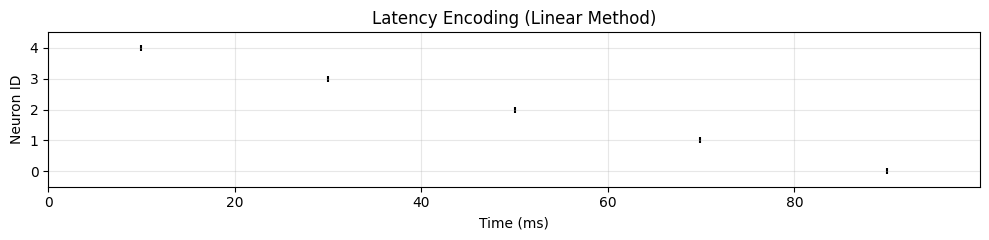

Log encoding spike times: [10.5  3.4  2.   1.4  1.1] ms


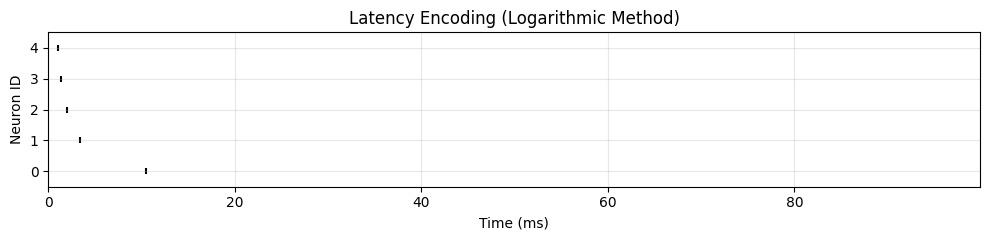

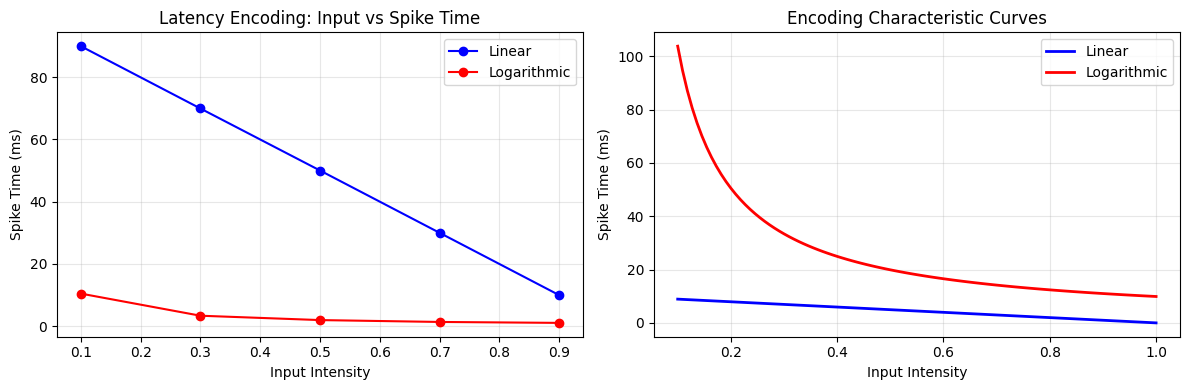


Latency encoding provides precise temporal coding where
stimulus intensity determines the exact timing of the first spike.


In [2]:
# Latency Encoding Examples
print("=== LATENCY ENCODING ===")

# Test data with different intensities
test_data = jnp.array([0.1, 0.3, 0.5, 0.7, 0.9])
n_time = 100  # 10 ms simulation

# Linear latency encoding
linear_encoder = LatencyEncoder(method='linear', normalize=True)
linear_spikes = linear_encoder(test_data, n_time=n_time)

print(f"Input data: {test_data}")
print(f"Linear encoding spike times: {jnp.argmax(linear_spikes, axis=0) * 0.1} ms")

plot_spikes(linear_spikes, "Latency Encoding (Linear Method)")

# Logarithmic latency encoding
log_encoder = LatencyEncoder(method='log', normalize=True)
log_spikes = log_encoder(test_data, n_time=n_time)

print(f"Log encoding spike times: {jnp.argmax(log_spikes, axis=0) * 0.1} ms")

plot_spikes(log_spikes, "Latency Encoding (Logarithmic Method)")

# Compare methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(test_data, jnp.argmax(linear_spikes, axis=0) * 0.1, 'bo-', label='Linear')
ax1.plot(test_data, jnp.argmax(log_spikes, axis=0) * 0.1, 'ro-', label='Logarithmic')
ax1.set_xlabel('Input Intensity')
ax1.set_ylabel('Spike Time (ms)')
ax1.set_title('Latency Encoding: Input vs Spike Time')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Show encoding characteristics
x_range = jnp.linspace(0.1, 1.0, 100)
linear_times = (n_time - 1) * (1 - x_range) * 0.1
log_times = (n_time - 1) * jnp.log(x_range / (x_range - 0.01)) * 0.1 / jnp.log(1 / 0.99)

ax2.plot(x_range, linear_times, 'b-', label='Linear', linewidth=2)
ax2.plot(x_range, log_times, 'r-', label='Logarithmic', linewidth=2)
ax2.set_xlabel('Input Intensity')
ax2.set_ylabel('Spike Time (ms)')
ax2.set_title('Encoding Characteristic Curves')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLatency encoding provides precise temporal coding where")
print("stimulus intensity determines the exact timing of the first spike.")

## 2. Rate Encoding

Rate encoding converts input values to firing rates. Higher inputs produce higher firing rates.

=== RATE ENCODING ===
Input values: [0.2 0.5 0.8]
Expected rates (Hz): [ 40. 100. 160.]
Actual rates (Hz): [ 40. 100. 170.]


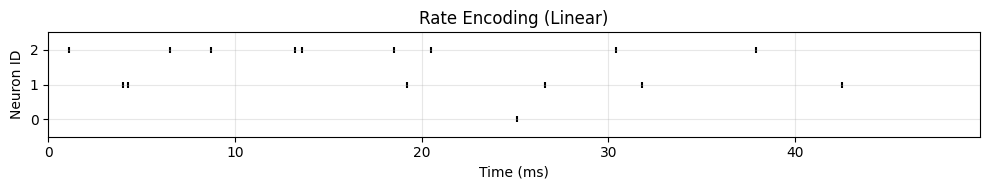

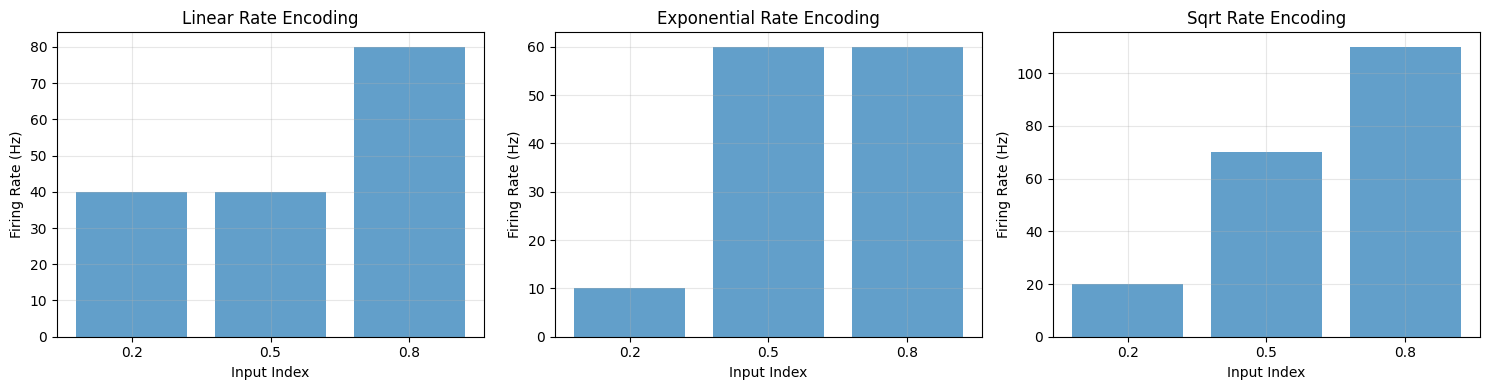


Rate encoding is widely used in artificial neural networks and
provides a direct analog to biological firing rate modulation.


In [3]:
# Rate Encoding Examples
print("=== RATE ENCODING ===")

test_inputs = jnp.array([0.2, 0.5, 0.8])
n_time = 1000  # 100 ms simulation

# Linear rate encoding
linear_rate_encoder = RateEncoder(gain=200, method='linear')
linear_rate_spikes = linear_rate_encoder(test_inputs, n_time=n_time)

# Calculate actual firing rates
actual_rates = jnp.sum(linear_rate_spikes, axis=0) * 10  # Convert to Hz
expected_rates = test_inputs * 200

print(f"Input values: {test_inputs}")
print(f"Expected rates (Hz): {expected_rates}")
print(f"Actual rates (Hz): {actual_rates}")

plot_spikes(linear_rate_spikes, "Rate Encoding (Linear)", time_window=500)

# Compare different rate encoding methods
methods = ['linear', 'exponential', 'sqrt']
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, method in enumerate(methods):
    encoder = RateEncoder(gain=100, method=method)
    spikes = encoder(test_inputs, n_time=1000)
    rates = jnp.sum(spikes, axis=0) * 10  # Convert to Hz
    
    axes[i].bar(range(len(test_inputs)), rates, alpha=0.7)
    axes[i].set_xlabel('Input Index')
    axes[i].set_ylabel('Firing Rate (Hz)')
    axes[i].set_title(f'{method.title()} Rate Encoding')
    axes[i].set_xticks(range(len(test_inputs)))
    axes[i].set_xticklabels([f'{x:.1f}' for x in test_inputs])
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRate encoding is widely used in artificial neural networks and")
print("provides a direct analog to biological firing rate modulation.")

## 3. Poisson Encoding

Poisson encoding generates spike trains with Poisson-distributed inter-spike intervals.

=== POISSON ENCODING ===
Input rates (Hz): [ 20  50 100]
Actual rates (Hz): [  0  30 140]


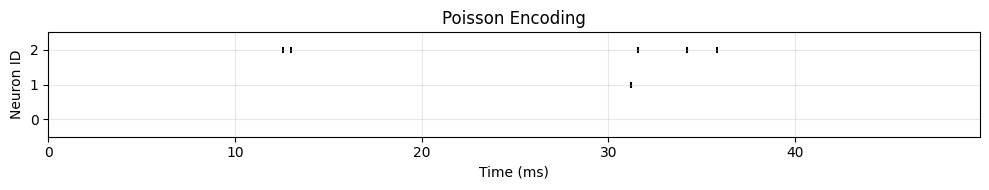

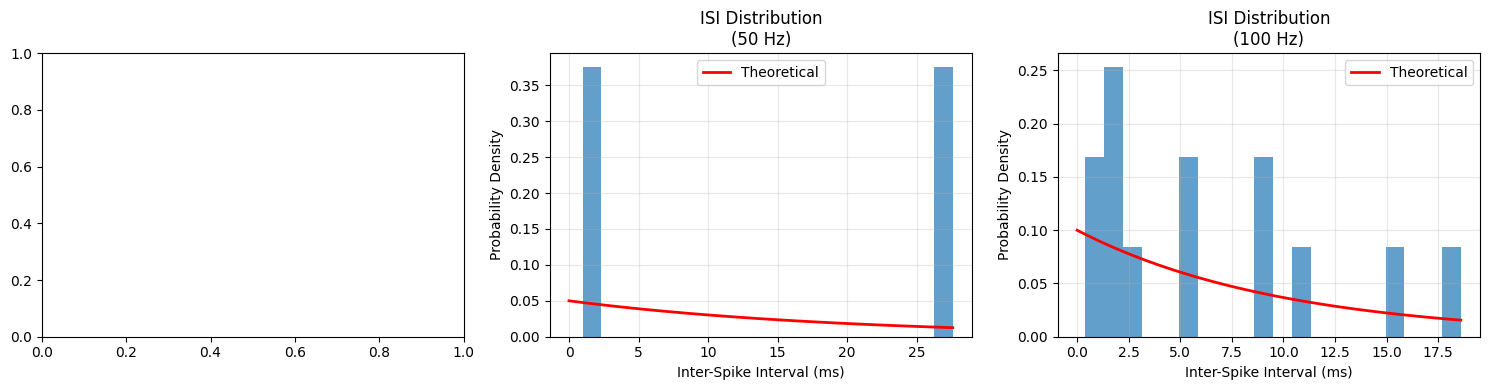


Poisson encoding introduces natural variability and is commonly
used to model stochastic neural activity.


In [4]:
# Poisson Encoding Examples
print("=== POISSON ENCODING ===")

rates = jnp.array([20, 50, 100])  # Hz
n_time = 1000  # 100 ms

poisson_encoder = PoissonEncoder()
poisson_spikes = poisson_encoder(rates, n_time=n_time)

print(f"Input rates (Hz): {rates}")
actual_rates = jnp.sum(poisson_spikes, axis=0) * 10
print(f"Actual rates (Hz): {actual_rates}")

plot_spikes(poisson_spikes, "Poisson Encoding", time_window=500)

# Analyze inter-spike intervals for Poisson process
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for neuron in range(3):
    spike_times = jnp.where(poisson_spikes[:, neuron])[0] * 0.1  # Convert to ms
    if len(spike_times) > 1:
        isis = jnp.diff(spike_times)
        axes[neuron].hist(isis, bins=20, alpha=0.7, density=True)
        axes[neuron].set_xlabel('Inter-Spike Interval (ms)')
        axes[neuron].set_ylabel('Probability Density')
        axes[neuron].set_title(f'ISI Distribution\n({rates[neuron]} Hz)')
        axes[neuron].grid(True, alpha=0.3)
        
        # Overlay theoretical exponential distribution
        x = jnp.linspace(0, jnp.max(isis), 100)
        rate_per_ms = rates[neuron] / 1000
        theoretical = rate_per_ms * jnp.exp(-rate_per_ms * x)
        axes[neuron].plot(x, theoretical, 'r-', linewidth=2, label='Theoretical')
        axes[neuron].legend()

plt.tight_layout()
plt.show()

print("\nPoisson encoding introduces natural variability and is commonly")
print("used to model stochastic neural activity.")

## 4. Population Encoding

Population encoding represents scalar values using a population of neurons with overlapping receptive fields.

=== POPULATION ENCODING ===


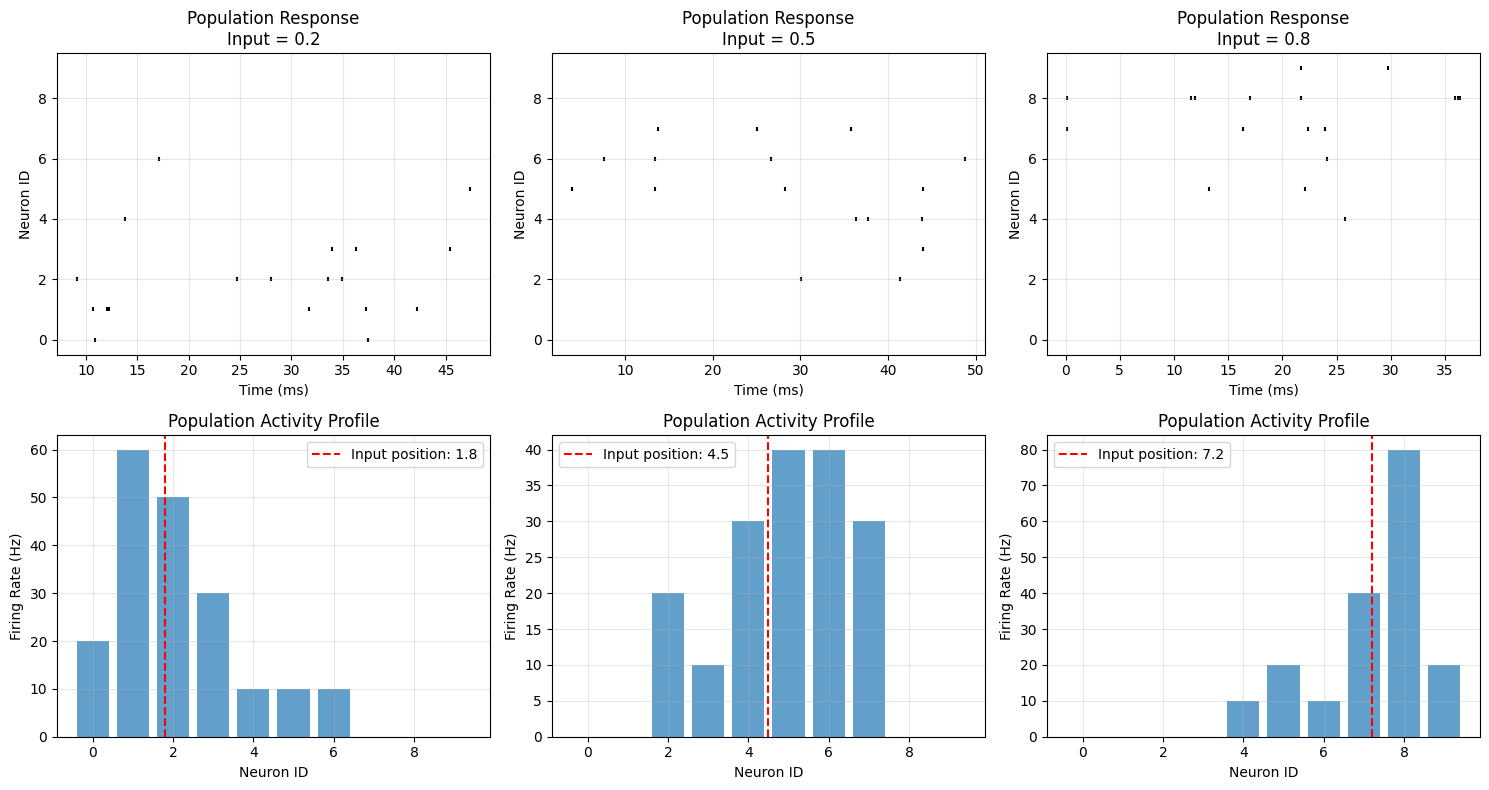

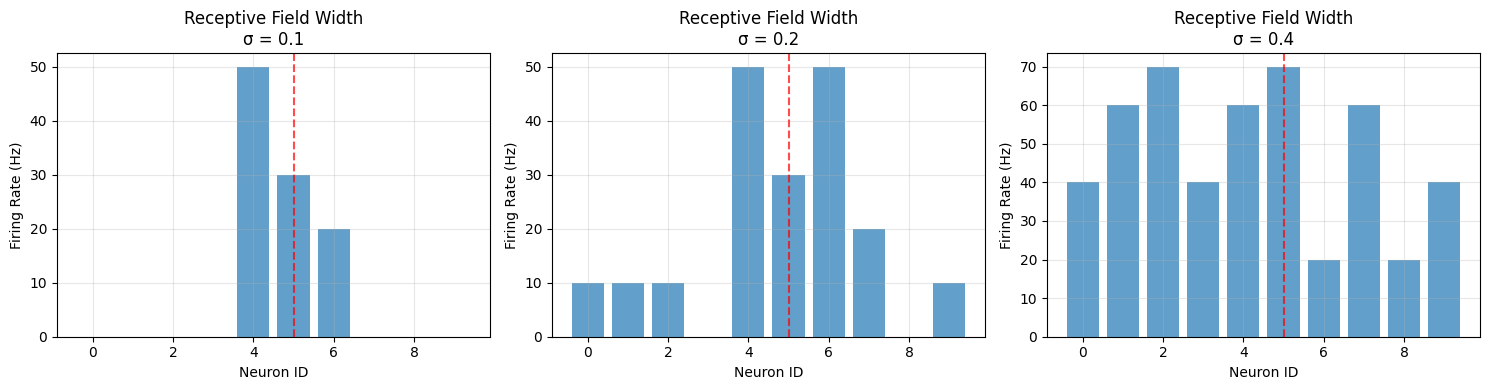


Population encoding provides robust representation and is
commonly used in sensory systems and neural prosthetics.


In [5]:
# Population Encoding Examples
print("=== POPULATION ENCODING ===")

# Encode different values with a population
pop_encoder = PopulationEncoder(n_neurons=10, min_val=0, max_val=1, sigma=0.2)
test_values = [0.2, 0.5, 0.8]
n_time = 500

fig, axes = plt.subplots(2, len(test_values), figsize=(15, 8))

for i, value in enumerate(test_values):
    pop_spikes = pop_encoder(value, n_time=n_time)
    
    # Plot spike trains
    for neuron in range(10):
        spike_times = jnp.where(pop_spikes[:, neuron])[0] * 0.1
        axes[0, i].scatter(spike_times, [neuron] * len(spike_times), 
                          s=10, c='black', marker='|')
    
    axes[0, i].set_xlabel('Time (ms)')
    axes[0, i].set_ylabel('Neuron ID')
    axes[0, i].set_title(f'Population Response\nInput = {value}')
    axes[0, i].set_ylim(-0.5, 9.5)
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot population activity profile
    firing_rates = jnp.sum(pop_spikes, axis=0) * 10  # Convert to Hz
    neuron_ids = jnp.arange(10)
    
    axes[1, i].bar(neuron_ids, firing_rates, alpha=0.7)
    axes[1, i].set_xlabel('Neuron ID')
    axes[1, i].set_ylabel('Firing Rate (Hz)')
    axes[1, i].set_title(f'Population Activity Profile')
    axes[1, i].grid(True, alpha=0.3)
    
    # Mark the input value position
    expected_peak = value * (10 - 1)
    axes[1, i].axvline(expected_peak, color='red', linestyle='--', 
                      label=f'Input position: {expected_peak:.1f}')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

# Demonstrate effect of receptive field width
sigmas = [0.1, 0.2, 0.4]
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

test_value = 0.5
for i, sigma in enumerate(sigmas):
    encoder = PopulationEncoder(n_neurons=10, sigma=sigma)
    spikes = encoder(test_value, n_time=500)
    rates = jnp.sum(spikes, axis=0) * 10
    
    axes[i].bar(range(10), rates, alpha=0.7)
    axes[i].set_xlabel('Neuron ID')
    axes[i].set_ylabel('Firing Rate (Hz)')
    axes[i].set_title(f'Receptive Field Width\nσ = {sigma}')
    axes[i].grid(True, alpha=0.3)
    axes[i].axvline(5, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\nPopulation encoding provides robust representation and is")
print("commonly used in sensory systems and neural prosthetics.")

## 5. Delta Encoding

Delta encoding generates spikes when the input signal changes significantly.

=== DELTA ENCODING ===
Standard: 4.0 spikes generated
Positive Only: 2.0 spikes generated
Absolute: 4.0 spikes generated


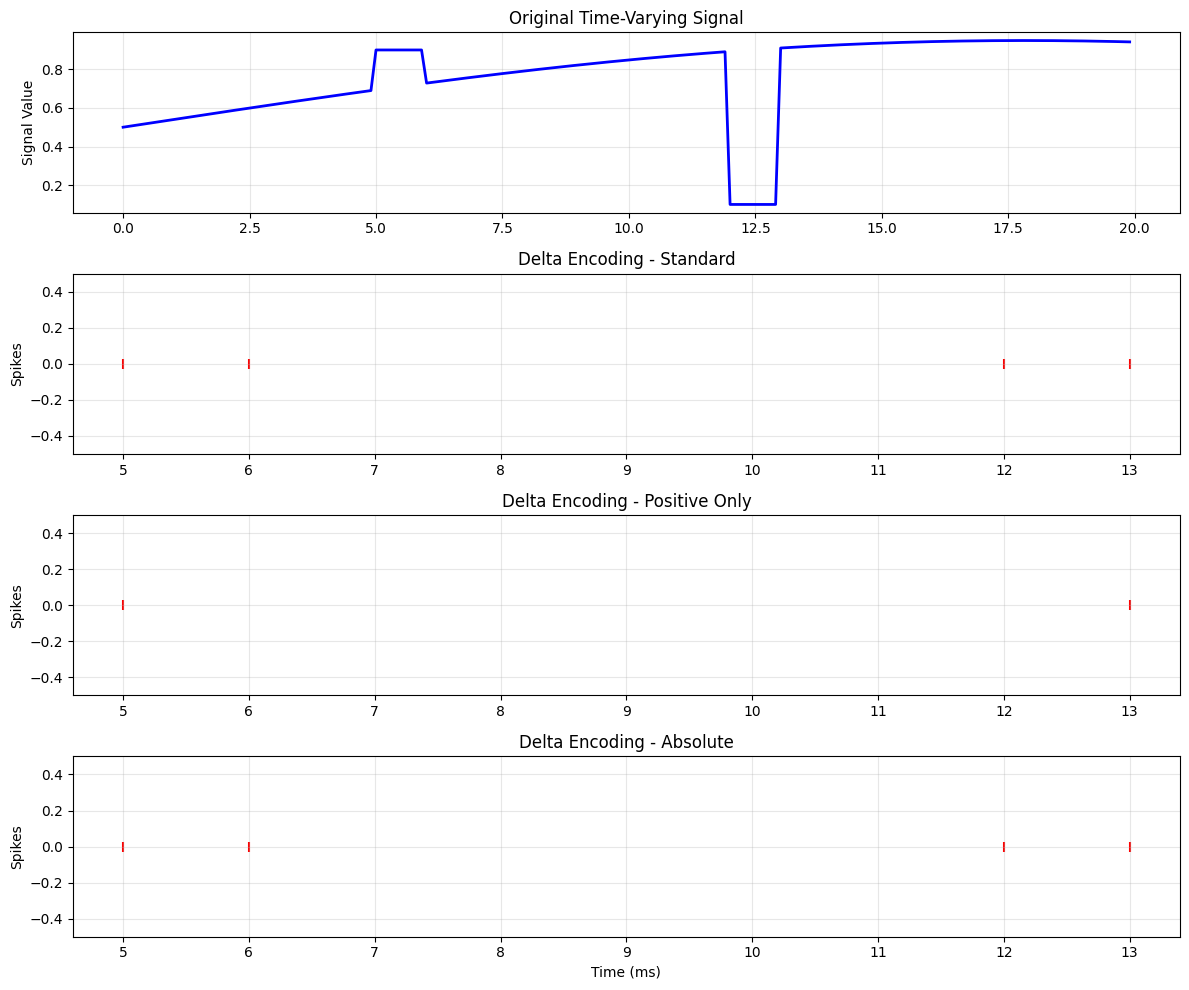


Multi-channel Delta Encoding:


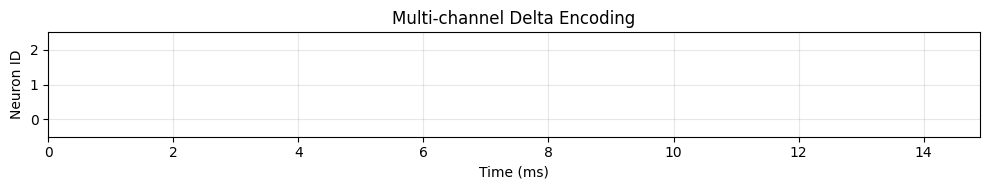


Delta encoding is efficient for representing dynamic signals
and is inspired by retinal ganglion cell responses.


In [6]:
# Delta Encoding Examples
print("=== DELTA ENCODING ===")

# Create a time-varying signal
time_steps = 200
t = jnp.arange(time_steps) * 0.1

# Smooth signal with sudden changes
signal = 0.5 + 0.3 * jnp.sin(0.1 * t) + 0.2 * jnp.sin(0.05 * t)
# Add some step changes
signal = signal.at[50:60].set(0.9)
signal = signal.at[120:130].set(0.1)

# Different delta encoding configurations
encoders = {
    'Standard': DeltaEncoder(threshold=0.05, absolute=False),
    'Positive Only': DeltaEncoder(threshold=0.05, positive_only=True),
    'Absolute': DeltaEncoder(threshold=0.05, absolute=True),
}

fig, axes = plt.subplots(len(encoders) + 1, 1, figsize=(12, 10))

# Plot original signal
axes[0].plot(t, signal, 'b-', linewidth=2)
axes[0].set_ylabel('Signal Value')
axes[0].set_title('Original Time-Varying Signal')
axes[0].grid(True, alpha=0.3)

# Plot delta encoded spike trains
for i, (name, encoder) in enumerate(encoders.items()):
    delta_spikes = encoder(signal)
    
    # Plot spikes
    spike_times = t[delta_spikes > 0]
    axes[i + 1].scatter(spike_times, [0] * len(spike_times), 
                       s=50, c='red', marker='|')
    axes[i + 1].set_ylabel('Spikes')
    axes[i + 1].set_title(f'Delta Encoding - {name}')
    axes[i + 1].set_ylim(-0.5, 0.5)
    axes[i + 1].grid(True, alpha=0.3)
    
    print(f"{name}: {jnp.sum(delta_spikes)} spikes generated")

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# Multi-channel delta encoding
print("\nMulti-channel Delta Encoding:")
# Create multiple signals
signals = jnp.array([
    0.5 + 0.3 * jnp.sin(0.1 * t),
    0.5 + 0.3 * jnp.cos(0.1 * t),
    0.5 + 0.2 * jnp.sin(0.2 * t)
]).T

multi_encoder = DeltaEncoder(threshold=0.1)
multi_spikes = multi_encoder(signals)

plot_spikes(multi_spikes, "Multi-channel Delta Encoding", time_window=150)

print("\nDelta encoding is efficient for representing dynamic signals")
print("and is inspired by retinal ganglion cell responses.")

## 6. Rank Order Encoding

Rank order encoding preserves the relative ordering of input features through spike timing.

=== RANK ORDER ENCODING ===
Ascending pattern - Spike order: [4 3 2 1 0]
  Corresponds to values: [0.9 0.7 0.5 0.3 0.1]
Descending pattern - Spike order: [0 1 2 3 4]
  Corresponds to values: [0.9 0.7 0.5 0.3 0.1]
Random pattern - Spike order: [3 1 4 0 2]
  Corresponds to values: [0.9 0.8 0.4 0.3 0.1]


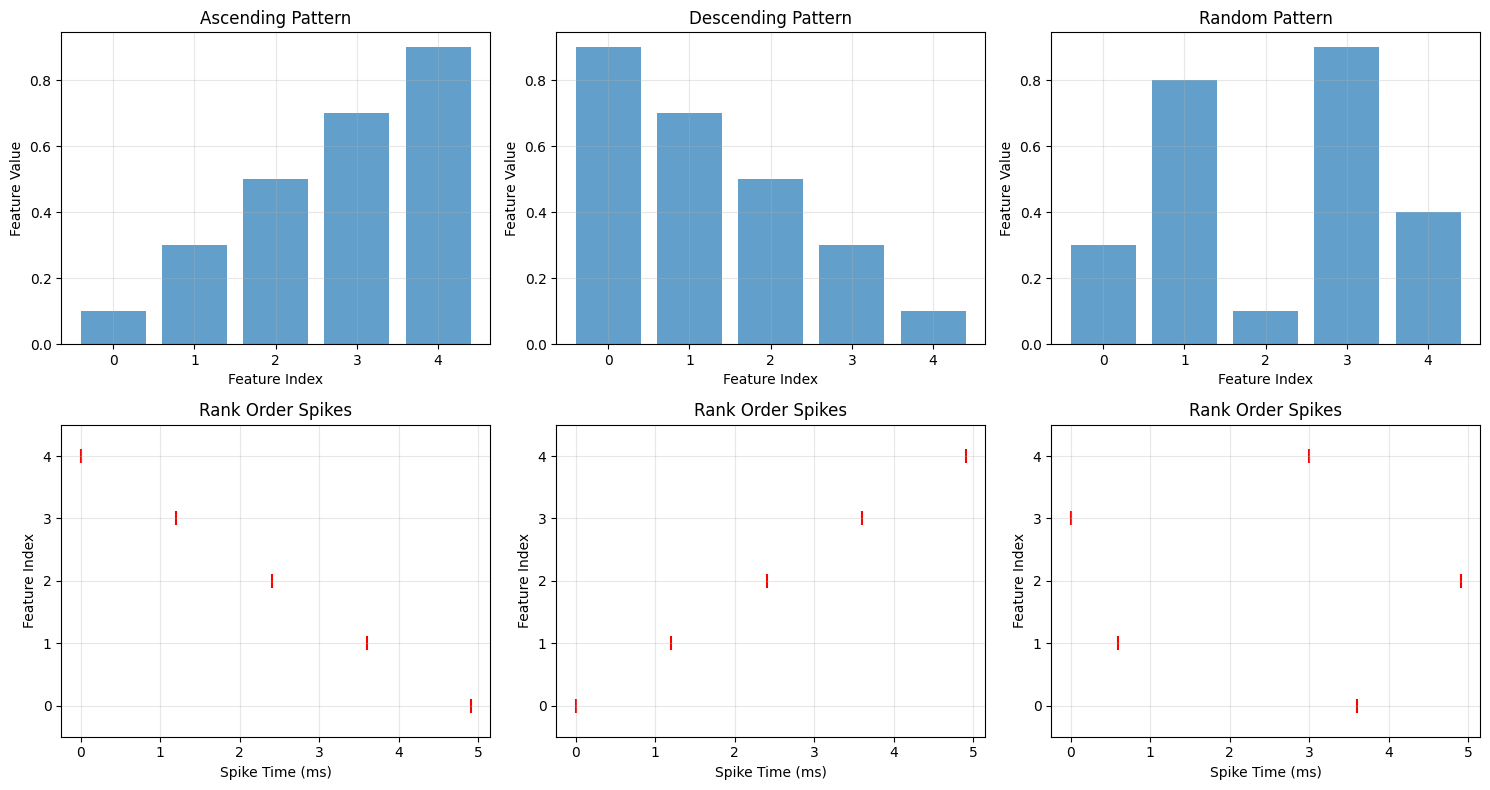

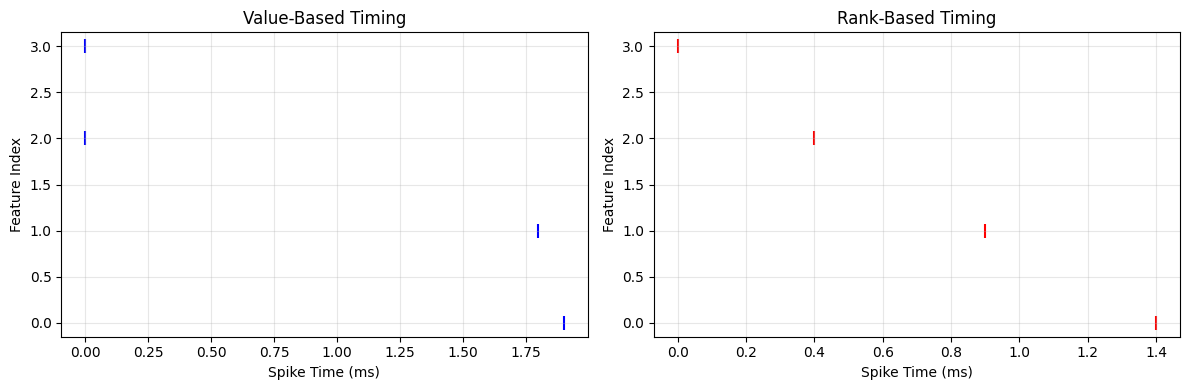

Test pattern: [0.1  0.11 0.9  0.91]
Value-based times: [1.9       1.8000001 0.        0.       ]
Rank-based times: [1.4        0.90000004 0.4        0.        ]

Rank order encoding preserves feature relationships and
is useful for pattern recognition tasks.


In [7]:
# Rank Order Encoding Examples
print("=== RANK ORDER ENCODING ===")

# Test with different input patterns
patterns = {
    'Ascending': jnp.array([0.1, 0.3, 0.5, 0.7, 0.9]),
    'Descending': jnp.array([0.9, 0.7, 0.5, 0.3, 0.1]),
    'Random': jnp.array([0.3, 0.8, 0.1, 0.9, 0.4]),
}

n_time = 50  # 5 ms encoding window

fig, axes = plt.subplots(2, len(patterns), figsize=(15, 8))

rank_encoder = RankOrderEncoder(use_values=True, normalize=True)

for i, (name, pattern) in enumerate(patterns.items()):
    # Encode pattern
    rank_spikes = rank_encoder(pattern, n_time=n_time)
    
    # Plot input pattern
    axes[0, i].bar(range(len(pattern)), pattern, alpha=0.7)
    axes[0, i].set_xlabel('Feature Index')
    axes[0, i].set_ylabel('Feature Value')
    axes[0, i].set_title(f'{name} Pattern')
    axes[0, i].grid(True, alpha=0.3)
    
    # Plot spike times
    spike_times = jnp.argmax(rank_spikes, axis=0) * 0.1  # Convert to ms
    for feature in range(len(pattern)):
        axes[1, i].scatter(spike_times[feature], feature, s=100, c='red', marker='|')
    
    axes[1, i].set_xlabel('Spike Time (ms)')
    axes[1, i].set_ylabel('Feature Index')
    axes[1, i].set_title(f'Rank Order Spikes')
    axes[1, i].set_ylim(-0.5, len(pattern) - 0.5)
    axes[1, i].grid(True, alpha=0.3)
    
    # Print spike order
    order = jnp.argsort(spike_times)
    print(f"{name} pattern - Spike order: {order}")
    print(f"  Corresponds to values: {pattern[order]}")

plt.tight_layout()
plt.show()

# Compare value-based vs rank-based encoding
test_pattern = jnp.array([0.1, 0.11, 0.9, 0.91])

value_encoder = RankOrderEncoder(use_values=True)
rank_encoder = RankOrderEncoder(use_values=False)

value_spikes = value_encoder(test_pattern, n_time=20)
rank_spikes = rank_encoder(test_pattern, n_time=20)

value_times = jnp.argmax(value_spikes, axis=0) * 0.1
rank_times = jnp.argmax(rank_spikes, axis=0) * 0.1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Value-based timing
for i in range(len(test_pattern)):
    ax1.scatter(value_times[i], i, s=100, c='blue', marker='|')
ax1.set_xlabel('Spike Time (ms)')
ax1.set_ylabel('Feature Index')
ax1.set_title('Value-Based Timing')
ax1.grid(True, alpha=0.3)

# Rank-based timing
for i in range(len(test_pattern)):
    ax2.scatter(rank_times[i], i, s=100, c='red', marker='|')
ax2.set_xlabel('Spike Time (ms)')
ax2.set_ylabel('Feature Index')
ax2.set_title('Rank-Based Timing')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Test pattern: {test_pattern}")
print(f"Value-based times: {value_times}")
print(f"Rank-based times: {rank_times}")

print("\nRank order encoding preserves feature relationships and")
print("is useful for pattern recognition tasks.")

## 7. Temporal Pattern Encoding

Temporal encoding creates synchronized spike patterns for sequence representation.

=== TEMPORAL ENCODING ===
Input sequence: [0 1 2 3 1 0 2]
Temporal spikes shape: (140, 4)


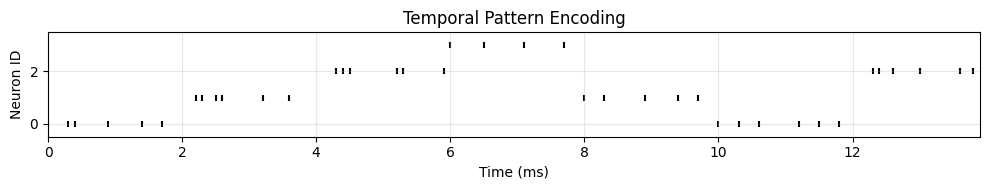

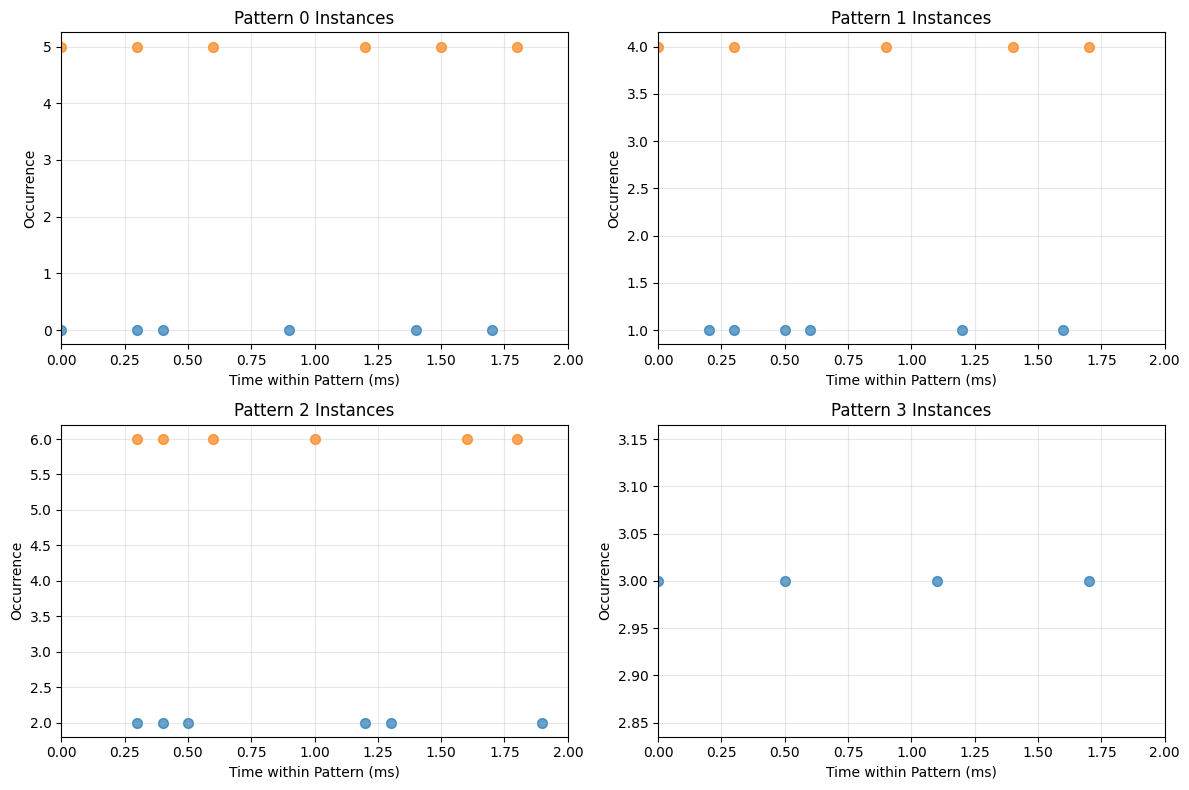

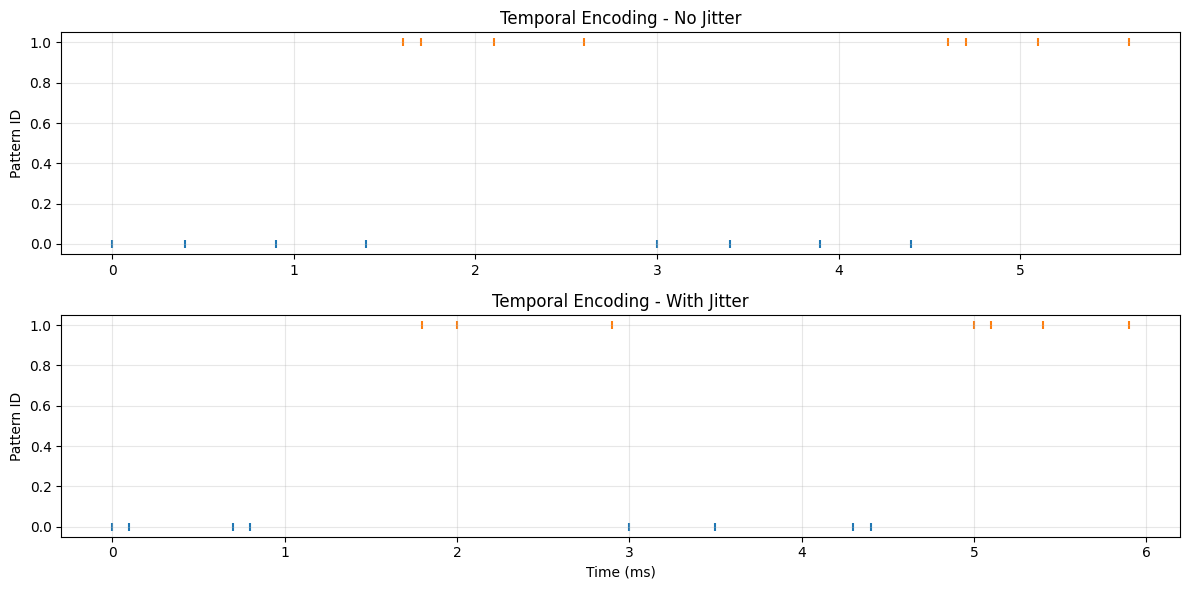


Temporal encoding provides robust sequence representation
with optional jitter for noise tolerance.


In [9]:
# Temporal Encoding Examples
print("=== TEMPORAL ENCODING ===")

# Create a temporal encoder for 4 different patterns
temporal_encoder = TemporalEncoder(n_patterns=4, pattern_length=20, jitter=0.1)

# Encode a sequence
sequence = jnp.array([0, 1, 2, 3, 1, 0, 2])
temporal_spikes = temporal_encoder(sequence)

print(f"Input sequence: {sequence}")
print(f"Temporal spikes shape: {temporal_spikes.shape}")

# Plot the temporal patterns
plot_spikes(temporal_spikes, "Temporal Pattern Encoding", time_window=140)

# Analyze patterns for each symbol
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

pattern_length = 20
for pattern_id in range(4):
    # Find occurrences of this pattern in the sequence
    occurrences = jnp.where(sequence == pattern_id)[0]
    
    if len(occurrences) > 0:
        # Extract all instances of this pattern
        for occ in occurrences:
            start_time = occ * pattern_length
            end_time = start_time + pattern_length
            pattern_spikes = temporal_spikes[start_time:end_time, pattern_id]
            spike_times = jnp.where(pattern_spikes)[0] * 0.1
            axes[pattern_id].scatter(spike_times, [occ] * len(spike_times), 
                                   s=50, alpha=0.7)
    
    axes[pattern_id].set_xlabel('Time within Pattern (ms)')
    axes[pattern_id].set_ylabel('Occurrence')
    axes[pattern_id].set_title(f'Pattern {pattern_id} Instances')
    axes[pattern_id].set_xlim(0, pattern_length * 0.1)
    axes[pattern_id].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Compare with and without jitter
no_jitter_encoder = TemporalEncoder(n_patterns=2, pattern_length=15, jitter=0.0)
jitter_encoder = TemporalEncoder(n_patterns=2, pattern_length=15, jitter=0.3)

test_sequence = jnp.array([0, 1, 0, 1])

no_jitter_spikes = no_jitter_encoder(test_sequence)
jitter_spikes = jitter_encoder(test_sequence)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Plot without jitter
for neuron in range(2):
    spike_times = jnp.where(no_jitter_spikes[:, neuron])[0] * 0.1
    ax1.scatter(spike_times, [neuron] * len(spike_times), s=30, marker='|')
ax1.set_ylabel('Pattern ID')
ax1.set_title('Temporal Encoding - No Jitter')
ax1.grid(True, alpha=0.3)

# Plot with jitter
for neuron in range(2):
    spike_times = jnp.where(jitter_spikes[:, neuron])[0] * 0.1
    ax2.scatter(spike_times, [neuron] * len(spike_times), s=30, marker='|')
ax2.set_xlabel('Time (ms)')
ax2.set_ylabel('Pattern ID')
ax2.set_title('Temporal Encoding - With Jitter')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTemporal encoding provides robust sequence representation")
print("with optional jitter for noise tolerance.")

## 8. Comparison and Summary

Let's compare different encoding methods on the same input data.

=== ENCODING METHOD COMPARISON ===
Input data: [0.2 0.5 0.8]
Rate (Linear): Total spikes = 4.0, Rates = [ 5. 10.  5.] Hz
Poisson: Total spikes = 3.0, Rates = [ 5.  0. 10.] Hz
Bernoulli: Total spikes = 60.0, Rates = [ 40. 105. 155.] Hz
Rank Order: Total spikes = 3.0, Rates = [20. 20. 20.] Hz


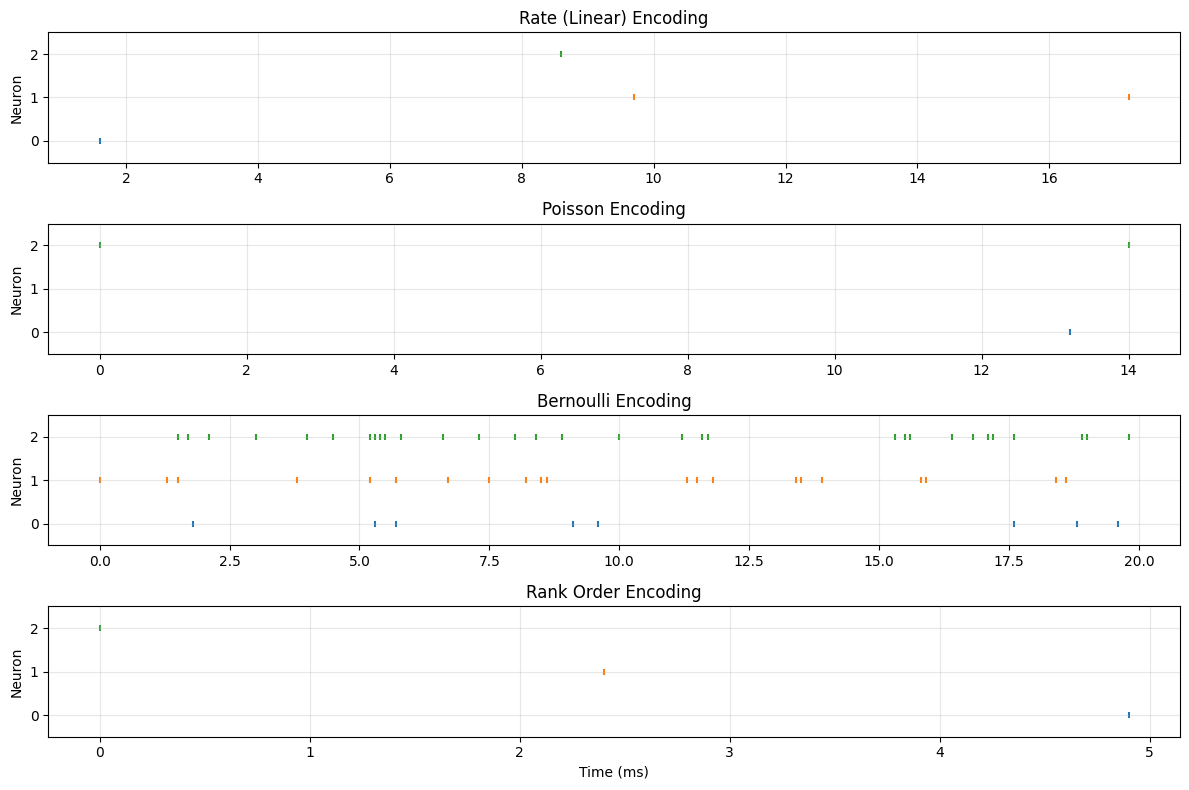


SPIKE ENCODING METHOD SUMMARY
Method          Input Type   Output          Key Features
--------------- ------------ --------------- -------------------------
Latency         Scalar/Vector Time-to-spike   Precise timing, energy efficient
Rate            Scalar/Vector Firing rate     Intuitive, noise robust
Poisson         Rates (Hz)   Stochastic spikes Natural variability
Population      Scalar       Distributed     Robust, biologically inspired
Bernoulli       Probabilities Independent     Simple, controllable
Delta           Time series  Change detection Efficient for dynamics
Step Current    Scalar/Vector Constant current For LIF neurons
Spike Count     Scalar/Vector Exact counts    Deterministic totals
Temporal        Sequences    Patterns        Sequence encoding
Rank Order      Vectors      Relative timing Order preservation

USAGE RECOMMENDATIONS:
• Rate/Poisson: General-purpose, biologically realistic
• Latency: Time-critical applications, energy efficiency
• Population: Robus

In [10]:
# Comparison of Encoding Methods
print("=== ENCODING METHOD COMPARISON ===")

# Common test data
test_data = jnp.array([0.2, 0.5, 0.8])
n_time = 200

# Configure encoders
encoders = {
    'Rate (Linear)': RateEncoder(gain=100, method='linear'),
    'Poisson': PoissonEncoder(normalize=True, max_rate=100),
    'Bernoulli': BernoulliEncoder(scale=0.2),
    'Rank Order': RankOrderEncoder(use_values=True),
}

fig, axes = plt.subplots(len(encoders), 1, figsize=(12, 2 * len(encoders)))

print(f"Input data: {test_data}")

for i, (name, encoder) in enumerate(encoders.items()):
    # Generate spikes
    if hasattr(encoder, '__call__'):
        if 'Poisson' in name or 'Bernoulli' in name:
            spikes = encoder(test_data, n_time=n_time)
        elif 'Rank' in name:
            spikes = encoder(test_data, n_time=50)  # Shorter for rank order
        else:
            spikes = encoder(test_data, n_time=n_time)
    
    # Plot spike trains
    plot_window = min(n_time, spikes.shape[0])
    for neuron in range(spikes.shape[1]):
        spike_times = jnp.where(spikes[:plot_window, neuron])[0] * 0.1
        axes[i].scatter(spike_times, [neuron] * len(spike_times), 
                       s=20, marker='|')
    
    axes[i].set_ylabel('Neuron')
    axes[i].set_title(f'{name} Encoding')
    axes[i].set_ylim(-0.5, 2.5)
    axes[i].grid(True, alpha=0.3)
    
    # Calculate and print statistics
    total_spikes = jnp.sum(spikes)
    spike_rates = jnp.sum(spikes, axis=0) * 1000 / spikes.shape[0]
    print(f"{name}: Total spikes = {total_spikes}, Rates = {spike_rates} Hz")

axes[-1].set_xlabel('Time (ms)')
plt.tight_layout()
plt.show()

# Summary table of encoding characteristics
print("\n" + "="*60)
print("SPIKE ENCODING METHOD SUMMARY")
print("="*60)

summary_data = [
    ["Method", "Input Type", "Output", "Key Features"],
    ["-"*15, "-"*12, "-"*15, "-"*25],
    ["Latency", "Scalar/Vector", "Time-to-spike", "Precise timing, energy efficient"],
    ["Rate", "Scalar/Vector", "Firing rate", "Intuitive, noise robust"],
    ["Poisson", "Rates (Hz)", "Stochastic spikes", "Natural variability"],
    ["Population", "Scalar", "Distributed", "Robust, biologically inspired"],
    ["Bernoulli", "Probabilities", "Independent", "Simple, controllable"],
    ["Delta", "Time series", "Change detection", "Efficient for dynamics"],
    ["Step Current", "Scalar/Vector", "Constant current", "For LIF neurons"],
    ["Spike Count", "Scalar/Vector", "Exact counts", "Deterministic totals"],
    ["Temporal", "Sequences", "Patterns", "Sequence encoding"],
    ["Rank Order", "Vectors", "Relative timing", "Order preservation"],
]

for row in summary_data:
    print(f"{row[0]:15} {row[1]:12} {row[2]:15} {row[3]}")

print("\n" + "="*60)
print("USAGE RECOMMENDATIONS:")
print("• Rate/Poisson: General-purpose, biologically realistic")
print("• Latency: Time-critical applications, energy efficiency")
print("• Population: Robust encoding, sensory processing")
print("• Delta: Dynamic signals, event-driven processing")
print("• Rank Order: Feature relationships, pattern recognition")
print("• Temporal: Sequence learning, temporal patterns")
print("="*60)